# Udacity Self-Driving Car Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#### import files system
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### input images read files 
import glob
import pickle

### Interactive widget, video IO processing utilities
from ipywidgets import interact, interactive, fixed  # widgets 
from moviepy.editor import VideoFileClip             # players
from IPython.display import HTML                     # Ipython

### (A) Image files - Read, basic preprocessing and visualisations
First section is dedicated to techniques and function used to read images, preprocess and visualise outcomes. In this section i tried;
(a) To read chessboard images
(b) BGR to Gray scale conversion
(c) Identify chessboard points
(d) Define system level paramters to avoid hard codings (corner points, Images path..etc)
(e) Define a few functions for later usages in project
(f) Visualize outcome of functions

In [2]:
#### System parameters
#### prepare object points
CAMERA_CAL_PATH = './camera_cal' # Path for calibration file 
CORNER_FOUND_FILE = './corner_found_file'
nx = 9         # Number of inside corners in x
ny = 6         # Number of inside corners in y

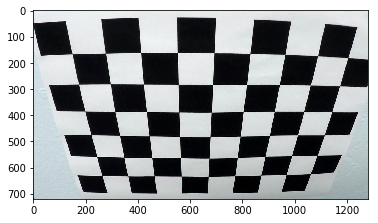

In [3]:
# Make a list of calibration images
fname = CAMERA_CAL_PATH + '/calibration2.jpg'
img = cv2.imread(fname)
image = cv2.imread(fname)
plt.imshow(img)

Image Chess board processing begin


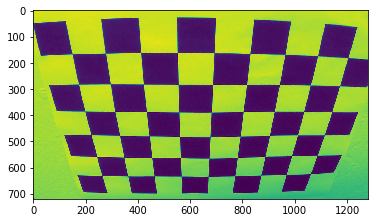

In [4]:
### Convert calibration image to grayscale
# Convert to grayscale
print("Image Chess board processing begin")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

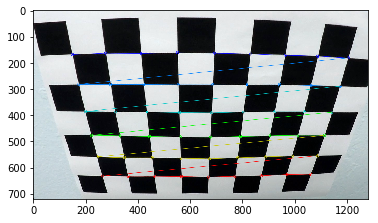

In [5]:
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img) 

Image Chess board processing done


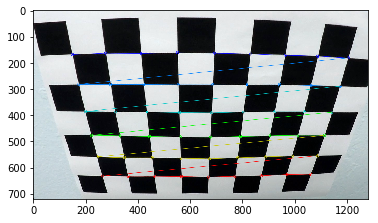

In [6]:
plt.imshow(img)    
print("Image Chess board processing done")

In [7]:
def main():  
    fname = CAMERA_CAL_PATH + '/calibration1.jpg'
    img = cv2.imread(fname)
    plt.imshow(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        plt.show() 

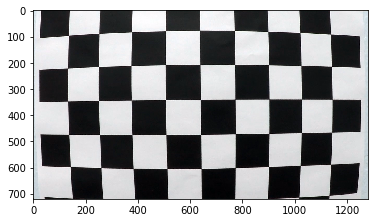

In [8]:
main()

In [9]:
def draw_chessboard_corners(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)

    if ret is True:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray_image, corners, (11, 11), (-1, -1), criteria)
        img = cv2.drawChessboardCorners(image, (nx, ny), corners2, ret)
    return image 

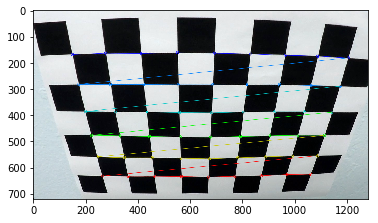

In [10]:
draw_chessboard_corners(image)
plt.imshow(img)
plt.show() 

### (B) Image files - Advance processing, warp and visualisations
This section define two function - corners_unward() & get_points()

Objective of unwarp is remove distortion, do gray scaling, identify corners and apply perspective transformation techniques.

Objective of get_points function is to identify corners and prepare lists of objectpoint & imagepoints.

(1) corner_unwarp() method description:
    (a) Inputs : Image, Nx, Ny, Undistored Image
    (b) Output : warped Image, Matrix (histogram)
    (c) algorithm : steps described as
        (i) Use the OpenCV undistort() function to remove distortion
        (ii) Convert undistorted image to grayscale
        (iii) Search for corners in the grayscaled image
        (iv) visualise images or write in a file (if desired)
        (v) Choose offset from image corners to plot detected corners
        (vi) This should be chosen to present the result at the proper aspect ratio
        (vii) Grab the image shape, outer four detected points & destination point
        (viii) Setup to visualize warped results
        (ix) do perspective transform
        (x) return result as image and matrix (histogram)
        
(2) get_point() method description:
    (a) Inputs : None
    (b) Outputs : objpoints, imgpoints
    (c) algorithm : 
        (i) prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        (ii) Initialize - Arrays to store object points and image points from all the images.
        (iii) Make a list of calibration images - use of glob function
        (iv) Step through the list and search for chessboard corners
        (v) Find the chessboard corners and plot on original image
        (vi) write processed output image in a file

In [11]:
def corners_unwarp(img, nx, ny, undistorted):
    Matrix = None
    warped = np.copy(img)
    
    undist = undistorted
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)  
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) 

    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100    # Set for a while
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        Matrix = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, Matrix, img_size)
    return warped, Matrix 

In [12]:
def get_points():
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1 , 2)
    objpoints = []    # 3d points in real world space
    imgpoints = []    # 2d points in image plane.
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    images = glob.glob(CAMERA_CAL_PATH + '/calibration*.jpg')
    
    # Plot set up 
    fig, axs = plt.subplots(5,4, figsize=(16, 11))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret == True: # If found, add object points, image points
            objpoints.append(objp)
            
            # this step to refine image points was taken from:
            # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            # imgpoints.append(corners) 
            
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret) # Draw and display the corners
            write_name = CORNER_FOUND_FILE + '/corners_found' + str(idx) + '.jpg'
            cv2.imwrite(write_name, img)
            
            # Display images
            axs[idx].axis('off')
            axs[idx].imshow(img)
            
            # cv2.imshow('img', img)
            # cv2.waitKey(500)
    # cv2.destroyAllWindows()
    return objpoints, imgpoints 

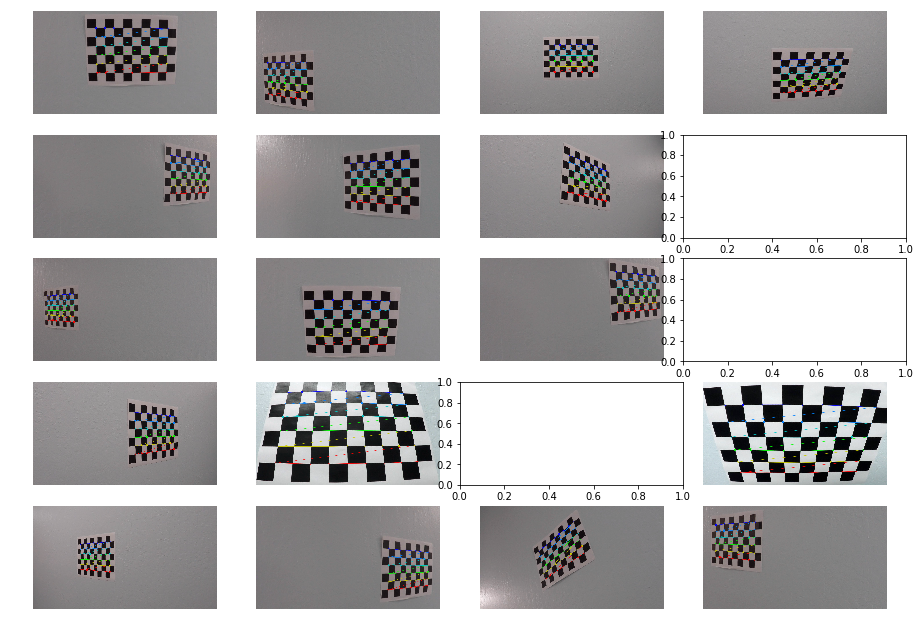

In [13]:
objpoints, imgpoints = get_points()

### (c) Display a sample of calibration and undistorted image
This section displays one sample of calibration image, one sample of undistorted image and ploting of one processes image which got undistorted. 

Output are also write in a file. 

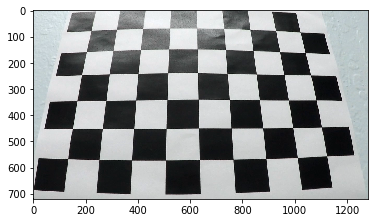

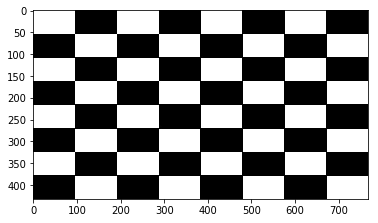

In [14]:
# calibration images for warp !
fname_warp = CAMERA_CAL_PATH + '/calibration3.jpg'
fname_undist = 'chessboard.jpg'
img = cv2.imread(fname_warp)
undist = cv2.imread(fname_undist, cv2.IMREAD_UNCHANGED)

plt.imshow(img)
plt.show()

plt.imshow(undist)
plt.show()

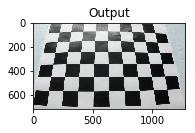

In [15]:
warped, Matrix = corners_unwarp(img, nx, ny, undist)
plt.subplot(122),plt.imshow(warped),plt.title('Output')
plt.show()

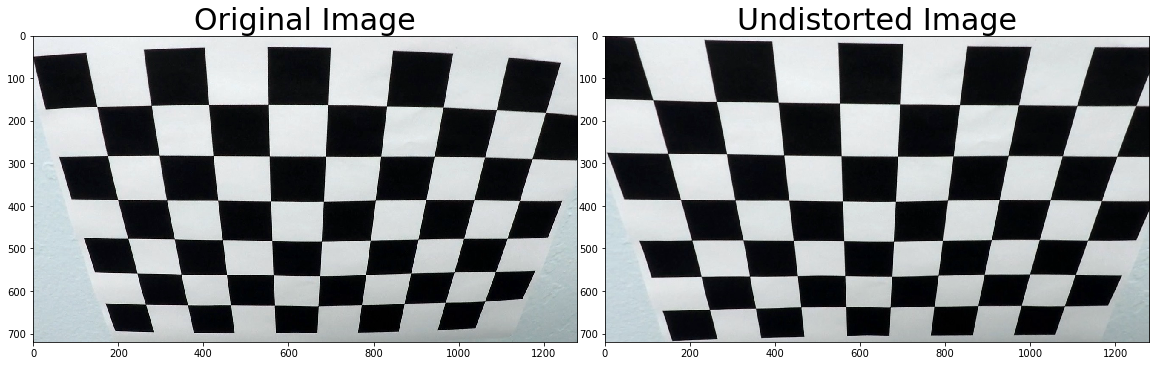

In [16]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### (d) Define common functions for images processing
This section is dedicated to defining generic functions. The list of functions which we defined are :
    (1) image_plot() : common function to plot
    (2) undistort() : function to undistort images
    (3) unwarp() : function to warp images
    (4) abs_sobel_thresh() : absolute thresold application
    (5) update() : Display sobel outcome 
    (6) mag_thresh() : image processing by magnitude thresold
    (7) update_sobel() : Display processed outcome
    (8) dir_thresh() : image process by direction thresold
    (9) update_sobeldir() : Display processed outcome
    (10) update_combined_MagDir() : Display processed outcome
    (11) hls_sthresh() : image processing for hls S thresold
    (12) update_sthresh() : Display processed outcome - hls S thresold outcome
    (13) hls_lthresh() : image process for hls L thresold 
    (14) update_lthresh() : Display processed outcome - hls L thresold outcome
    (15) lab_bthresh() : image process for LAB thresolds
    (16) update_lab() : Display processed outcome - LAB thresold outcome

In [17]:
### Function Definitions - Plot, Undistort, warp, 
def image_plot(ORIGINAL_IMAGE, PROCESSED_IMAGE, figsize, fontsize):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize)
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(ORGINAL_IMAGE, fontsize)
    ax2.imshow(undistorted)
    ax2.set_title(PROCESSED_IMAGE, fontsize)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return

def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def unwarp(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sxbinary   # Remove this line
    return binary_output

def update(min_thresh, max_thresh):
    exImg_sobelAbs = abs_sobel_thresh(exImg_unwarp, 'x', min_thresh, max_thresh)
    # visualize 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exImg_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=30)
    return

def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    binary_output = np.copy(sxbinary) 
    return binary_output

def update_sobel(kernel_size, min_thresh, max_thresh):
    exImg_sobelMag = mag_thresh(exImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exImg_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=30)
    return

def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output

def update_sobelDir(kernel_size, min_thresh, max_thresh):
    exImg_sobelDir = dir_thresh(exImg_unwarp, kernel_size, (min_thresh, max_thresh))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exImg_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=30)
    return

def update_combind_MagDir(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    exImg_sobelMag2 = mag_thresh(exImg_unwarp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    exImg_sobelDir2 = dir_thresh(exImg_unwarp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(exImg_sobelMag2)
    combined[((exImg_sobelMag2 == 1) & (exImg_sobelDir2 == 1))] = 1
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=30)
    return

def hls_sthresh(img, thresh=(125, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output

def update_sthresh(min_thresh, max_thresh):
    exImg_SThresh = hls_sthresh(exImg_unwarp, (min_thresh, max_thresh))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exImg_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=30)
    
def hls_lthresh(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    return binary_output

def update_lthresh(min_thresh, max_thresh):
    exImg_LThresh = hls_lthresh(exImg_unwarp, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exImg_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)
    
def lab_bthresh(img, thresh=(190,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

def update_lab(min_b_thresh, max_b_thresh):
    exImg_LBThresh = lab_bthresh(exImg_unwarp, (min_b_thresh, max_b_thresh))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)
    return

### (E) Example : Test_Images Processing (different types)
Choose an image from test_images to build and demonstrate each step of the pipeline.

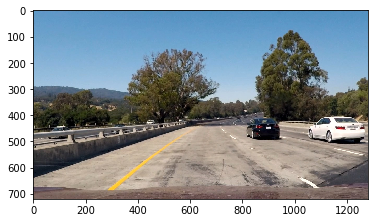

In [18]:
exImg = cv2.imread('./test_images/test1.jpg')
exImg = cv2.cvtColor(exImg, cv2.COLOR_BGR2RGB)
plt.imshow(exImg)

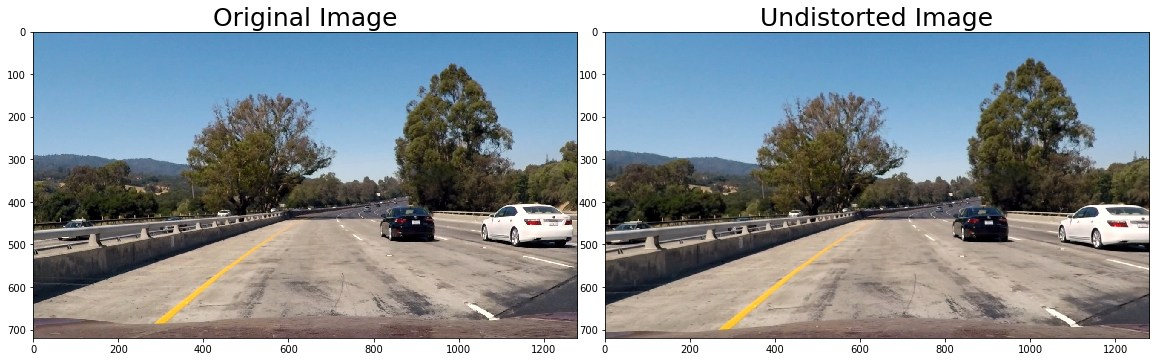

In [19]:
exImg_undistort = undistort(exImg)
h,w = exImg_undistort.shape[:2]

# Visualize undistortion & Original Images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exImg)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(exImg_undistort)
ax2.set_title('Undistorted Image', fontsize=25)

In [20]:
### define source and destination points for transform
src = np.float32([(575,464), (707,464), (258,682), (1049,682)])
dst = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])
exImg_unwarp, M, Minv = unwarp(exImg_undistort, src, dst)

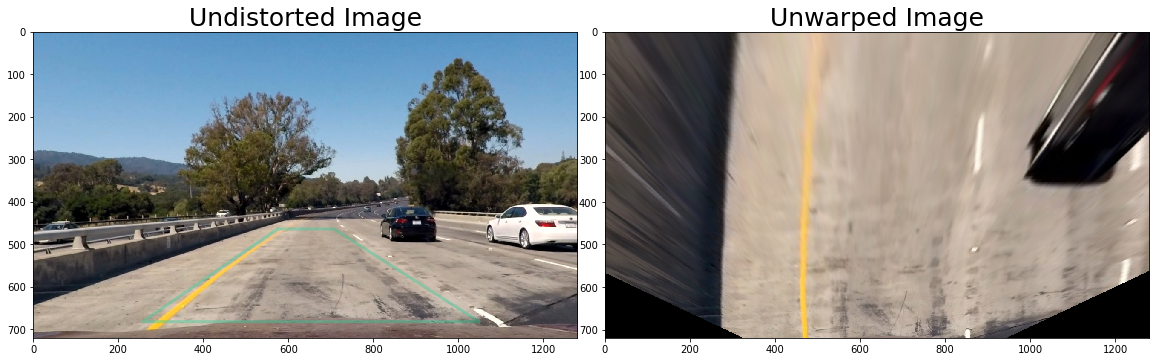

In [21]:
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(exImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=25)

### Visualizing multiple colour space channels

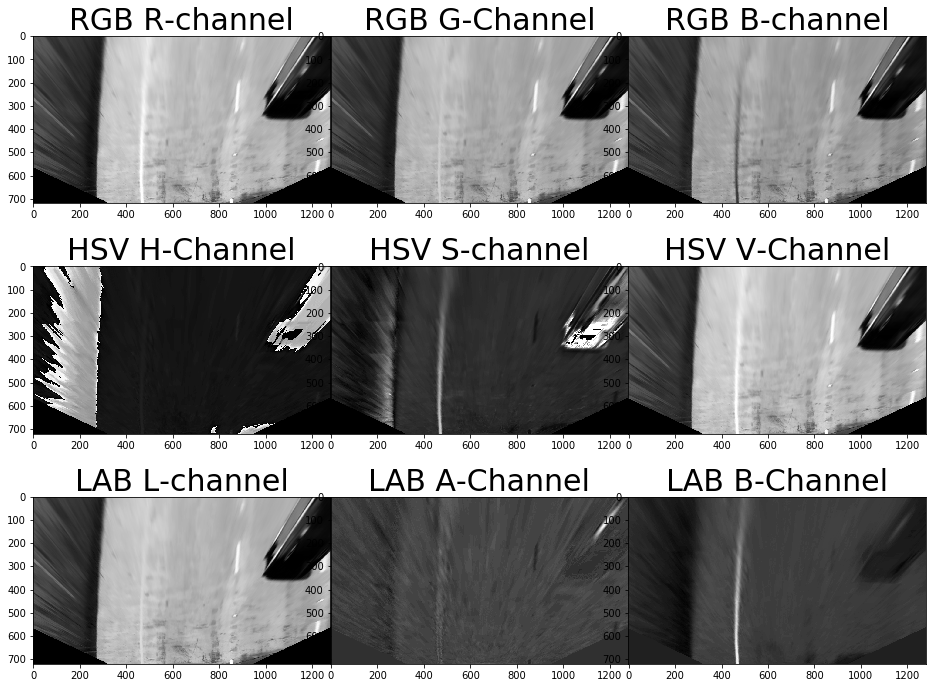

In [22]:
### Visualize multiple color space channels
## RGB to HSV
exImg_unwarp_R = exImg_unwarp[:,:,0]
exImg_unwarp_G = exImg_unwarp[:,:,1]
exImg_unwarp_B = exImg_unwarp[:,:,2]
exImg_unwarp_HSV = cv2.cvtColor(exImg_unwarp, cv2.COLOR_RGB2HSV)

## RGB to Lab
exImg_unwarp_H = exImg_unwarp_HSV[:,:,0]
exImg_unwarp_S = exImg_unwarp_HSV[:,:,1]
exImg_unwarp_V = exImg_unwarp_HSV[:,:,2]
exImg_unwarp_LAB = cv2.cvtColor(exImg_unwarp, cv2.COLOR_RGB2Lab)

## RGB to 
exImg_unwarp_L = exImg_unwarp_LAB[:,:,0]
exImg_unwarp_A = exImg_unwarp_LAB[:,:,1]
exImg_unwarp_B2 = exImg_unwarp_LAB[:,:,2]

## Visulize component
fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].imshow(exImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[1].imshow(exImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[2].imshow(exImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)

axs[3].imshow(exImg_unwarp_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=30)
axs[4].imshow(exImg_unwarp_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=30)
axs[5].imshow(exImg_unwarp_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=30)

axs[6].imshow(exImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=30)
axs[7].imshow(exImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=30)
axs[8].imshow(exImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=30)

### Sobel absolute threshold
SObel absolute thresold calculation and thresold visualisation

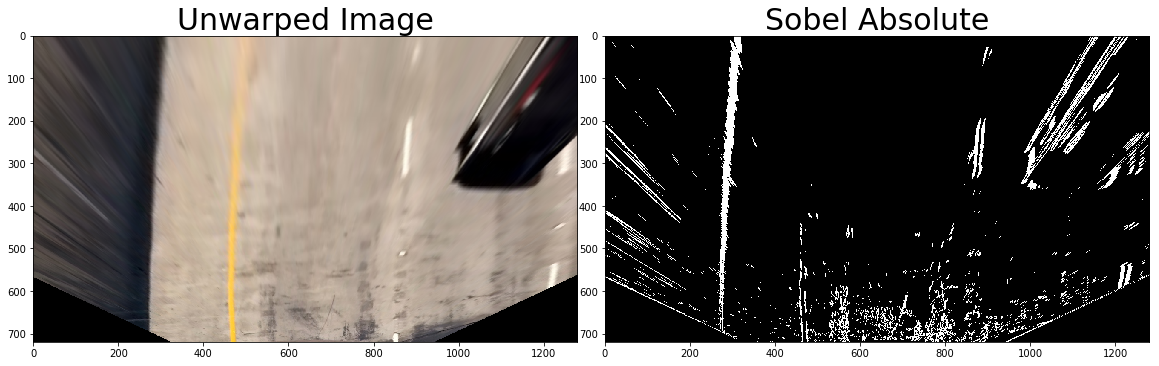

In [23]:
interact(update, min_thresh=(0,255), max_thresh=(0,255)) # 14 & 90 gives good result

### Sobel Magnitude Threshold
Sobel magnitude thresold impact and visualtion

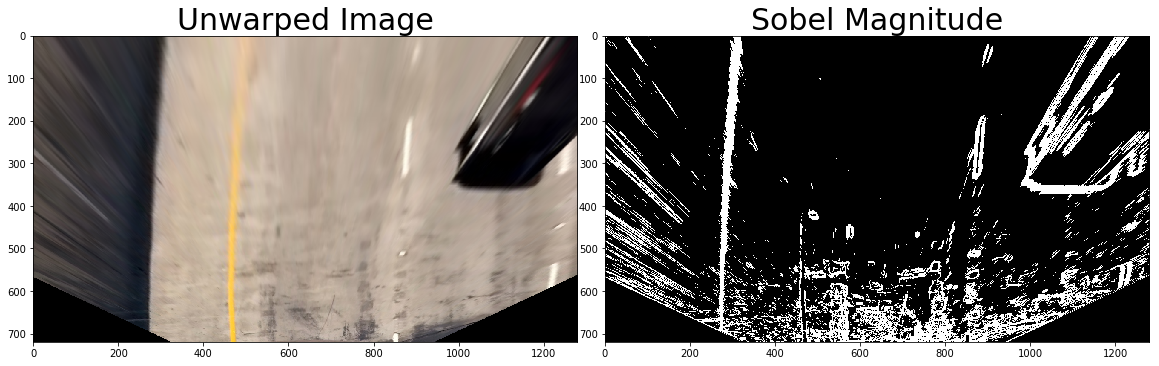

In [24]:
interact(update_sobel, kernel_size=(1,31,2), min_thresh=(0,255), max_thresh=(0,255)) # 15, 5 and 104

### Sobel Direction Threshold
Sobel direction application and visualize outcome

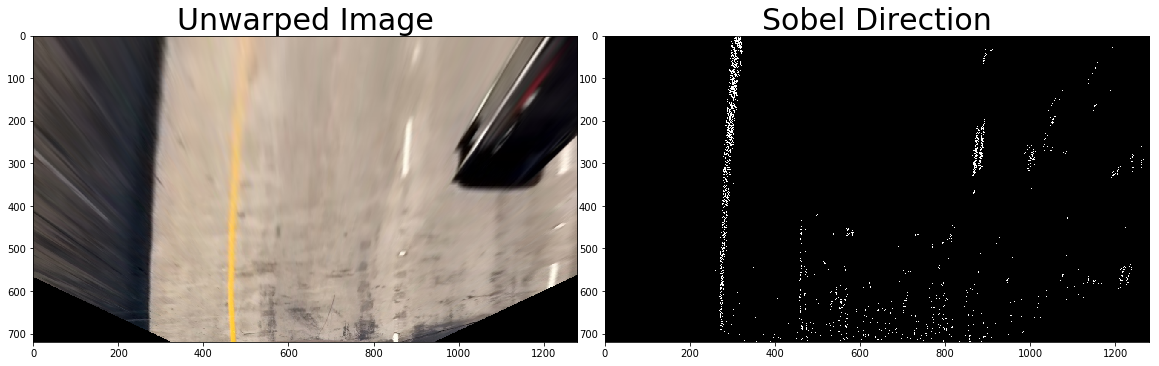

In [25]:
interact(update_sobelDir, kernel_size=(1,31,2), min_thresh=(0,np.pi/2,0.01), max_thresh=(0,np.pi/2,0.01))
# 1, 0.05 and 0.16 are typical values

### Sobel Magnitude and Direction Threshold combined impact
Apply sobel magnitude and direction thresold simultenously to analyse impact. Visualisation shows results. 

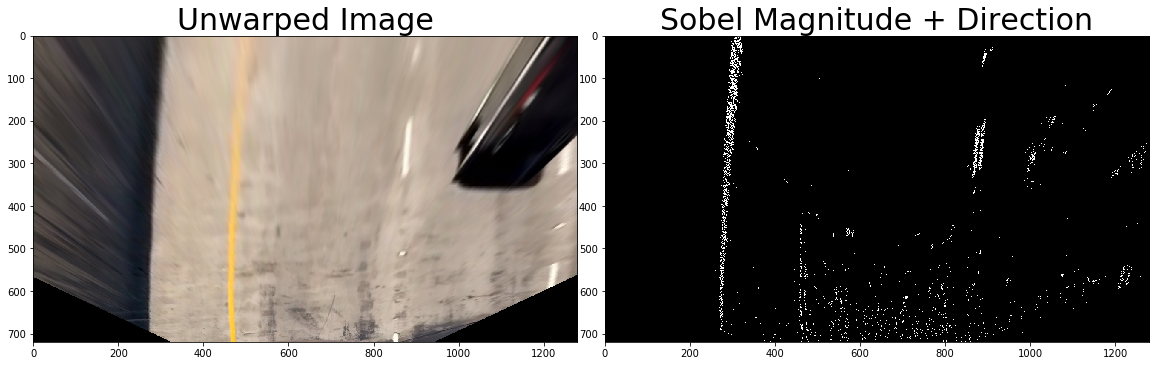

In [26]:
interact(update_combind_MagDir, 
                 mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01)) 

# Set values for outcome - (a) Mag - 11, 5, 117 (b) Dir - 3, 0.06, 0.18

### HLS S-Channel Threshold
Applying HLS S-channel thresold and visualise same.

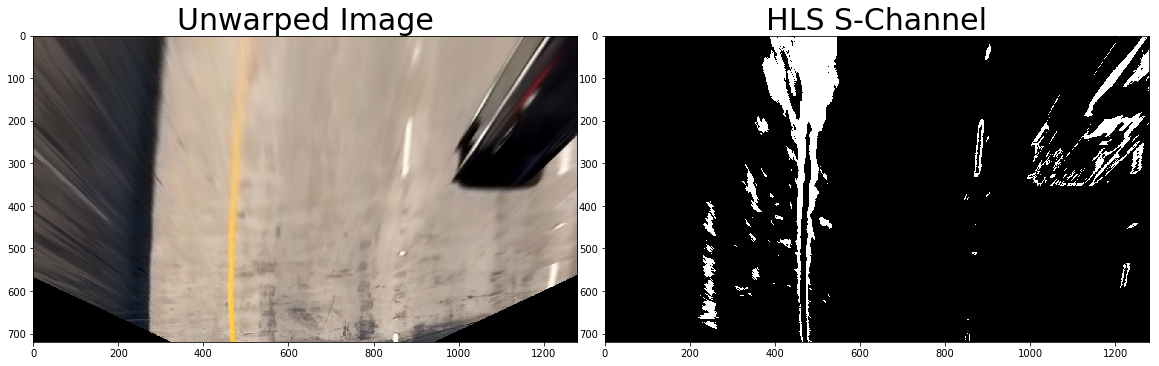

In [27]:
interact(update_sthresh, min_thresh=(0,255), max_thresh=(0,255)) # 77, 181

### HLS L-channel
Analyse L-channel thresolds and visualise HLS L-channel outcome.

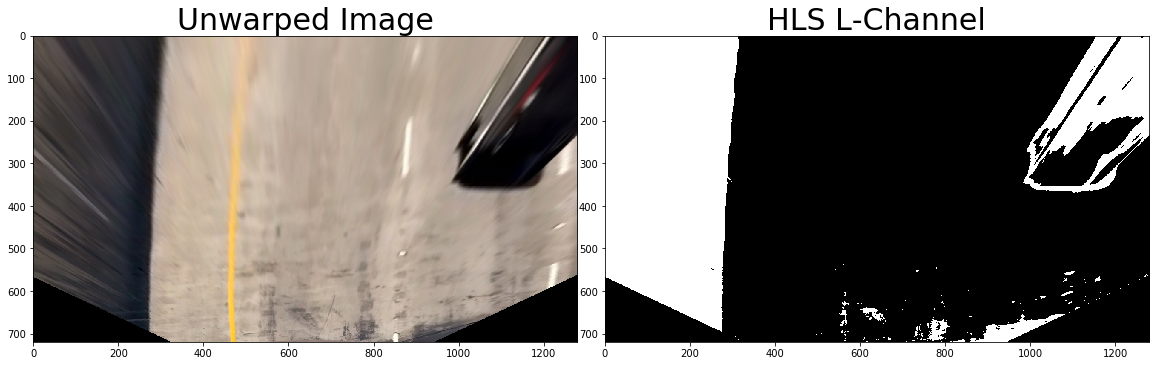

In [28]:
interact(update_lthresh, min_thresh=(0,255), max_thresh=(0,255)) #11, 126

### Lab colour space
Analysing LAB colours space and visulase

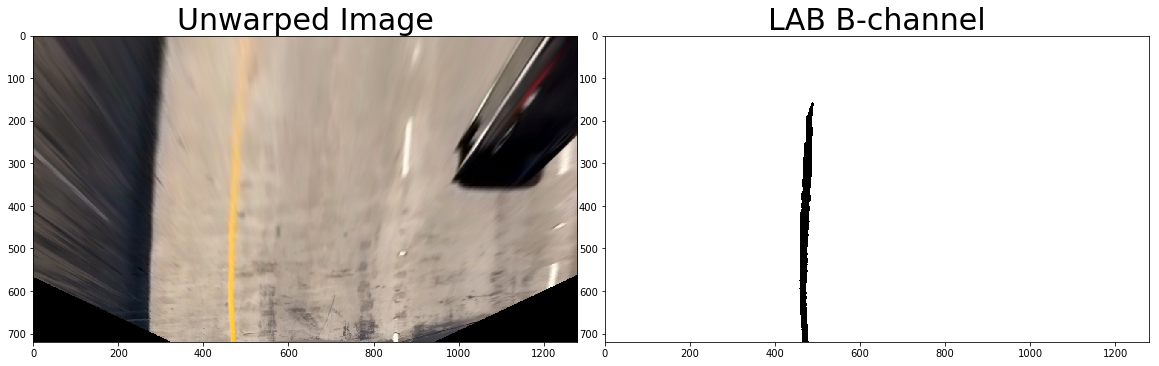

In [29]:
interact(update_lab, min_b_thresh=(0,255), max_b_thresh=(0,255)) # 59 and 192 - yellow line identified

## (F) Define a process pipeline  & Run
Defining a pipline to process individual images, run and visualise outcome.

In [30]:
def pipeline_process(img):
    img_undistort = undistort(img)
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)
    img_LThresh = hls_lthresh(img_unwarp)
    img_BThresh = lab_bthresh(img_unwarp)
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

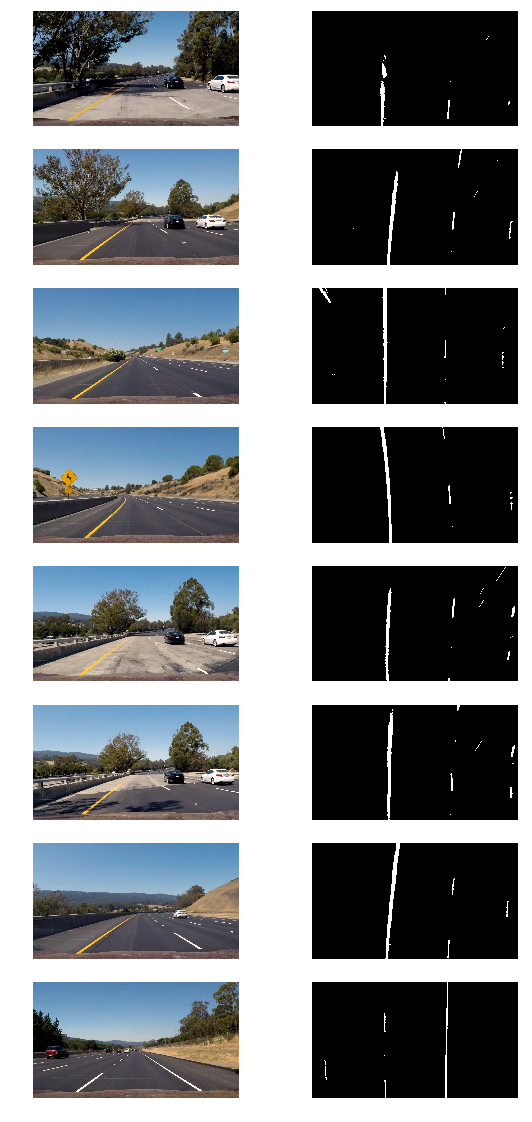

In [31]:
# Make a list of test example images & set up plot
images = glob.glob('./test_images/*.jpg')
                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

### run pipeline for all images processing
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline_process(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

## (G) Sliding windows polyfit
Define function to fit polynomial to binary image with lines extracted and using sliding window. Steps follwed in progression - 
(a) Pick histogram of the bottom half of the image
(b) Find the peak of the left and right halves of the histogram
(c) These will be the starting point for the left and right lines
(d) Previously the left/right base was the max of the left/right half of the histogram
(e) This changes it so that only a quarter of the histogram (directly to the left/right) is considered

#### Initial variable setup
(a) define number of sliding windows
(b) Calculate hieght of each window
(c) Identify x & y positions of all nonzero pixels (in the image)
(d) Current positions to be updated for each window (before iterations)
(e) Set width of the windows with +/- margin 
(f) Create empty lists to receive left and right lane pixel indices
(g) Creat empty list for rectangle data visualization

#### Step through defined windows (nwindows) step by step
Processing done in each window follows steps:
(a) Identify window boundaries in x/y & right/left)
(b) Setup rectangle data
(c) Identify the nonzero pixels in x and y within the window
(d) Append these indices to the lists
(e) check (If you found > minpix pixels) - recenter next window on their mean position

##### Concatanation & prepare visualisation data of outcome (nwindows)
(a) Concatenate the arrays of indices (left/right lanes)
(b) Extract left and right line pixel positions
(c) Fit a second order polynomial to each (Left/righr pixels)
(d) Prepare data for visualization 

In [32]:
def sliding_window_polyfit(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point ## Left/Right bases
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
   
    ## Setup initial variables
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    nonzero = img.nonzero()        # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base     # Current positions to be updated for each window
    rightx_current = rightx_base
    margin = 80                    # Set the width of the windows +/- margin
    minpix = 40                    # Set minimum number of pixels found to recenter window
    left_lane_inds = []  # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []
    rectangle_data = []  # Rectangle data for visualization

    for window in range(nwindows):     # Step through the windows one by one
        win_y_low = img.shape[0] - (window+1)*window_height 
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
       
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)  # Concatenate the arrays of indices
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]  # Extract left and right line pixel positions
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit, right_fit = (None, None)
    
    if len(leftx) != 0:    # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    visualization_data = (rectangle_data, histogram)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

### Visualize sliding window polyfit
Here is step for a simple visualization of image. 
(a) Initial step - Read image, process image and apply polyfit
(b) extract image height & number of rectangles/histograms returned
(c) Second step - create output image as;
(d) Generate x and y values for plotting
(e) Identify the x and y positions of all nonzero pixels in the image
(f) Plot outcome of image
(g) Print histogram from sliding window polyfit (for example image)

In [33]:
### Initial Step
exImg = cv2.imread('./test_images/test4.jpg')
exImg = cv2.cvtColor(exImg, cv2.COLOR_BGR2RGB)
exImg_bin, Minv = pipeline_process(exImg) # Image process step execution
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exImg_bin)

### Height image & extraction of each rectangles, histogram 
h = exImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

In [34]:
### Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exImg_bin, exImg_bin, exImg_bin))*255)
ploty = np.linspace(0, exImg_bin.shape[0]-1, exImg_bin.shape[0] ) # Generate x and y values for plotting
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rect in rectangles: # Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

(720, 0)

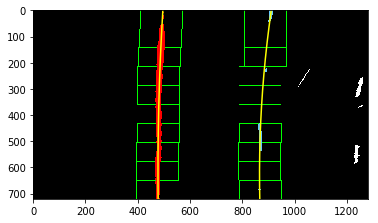

In [35]:
### Identify the x and y positions of all nonzero pixels in the image
nonzero = exImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

plt.imshow(out_img) ## Plot steps
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(0, 1600)

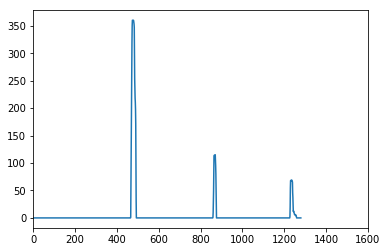

In [36]:
plt.plot(histogram) # Print histogram from sliding window polyfit
plt.xlim(0, 1600)

### Polyfit using Fit from previous frame
The test images "test2, test3 & test4" appear respectively i.e in chronologically ordered as frames of a single video capture. Here is function defined to process images set:
(a) Define a function for input (binary_warped, left_fit_prev, right_fit_prev)
(b) Initialize variables for position, margin and lanes
(c) Extract left and right line pixel positions (x and y)
(d) Fit a second order polynomial to each position - if pixel available

In [37]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)  # Fit a second order polynomial to each
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

### Visualize outcome of polyfit (using fit from previous frame)
Here is step for a simple visualization of image. 
(a) Initial step - Read image, process image and apply polyfit
(b) extract image height & number of rectangles/histograms returned
(c) Second step - create output image as;
(d) Generate x and y values for plotting
(e) Identify the x and y positions of all nonzero pixels in the image
(f) Plot outcome of image
(g) Print histogram from sliding window polyfit (for example image)

In [38]:
#### visualize the result on example image
exImg2 = cv2.imread('./test_images/test4.jpg')
exImg2 = cv2.cvtColor(exImg2, cv2.COLOR_BGR2RGB)
exImg2_bin, Minv = pipeline_process(exImg2)   
margin = 80
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exImg2_bin, left_fit, right_fit)

In [39]:
#### Generate x and y values for plotting
ploty = np.linspace(0, exImg2_bin.shape[0]-1, exImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

In [40]:
#### Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exImg2_bin, exImg2_bin, exImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

In [41]:
#### Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

(720, 0)

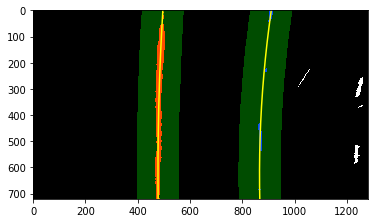

In [42]:
#### Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Radius of curvature and distance from lane center
A function defined to calculated curvature radius and distance from lane centre. Here is steps followed in doing so:
1. Processes:
(a) In summary function is based on binary image, polynomial fit, and L and R lane pixel indices
(b) Define conversions in x and y from pixels space to meters
(c) Define y-value where we want radius of curvature
(d) I'll choose the maximum y-value, corresponding to the bottom of the image
(e) Identify the x and y positions of all nonzero pixels in the image
(f) Extract left and right line pixel positions
(g) Fit new polynomials to x,y in world space
(h) Calculate the new radii of curvature
(i) Distance from center is image x midpoint - mean of l_fit and r_fit intercepts

2. Function Inputs: 
   bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds
   
3. Function Output:
   left_curverad, right_curverad, center_dist

In [43]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
    nonzero = bin_img.nonzero()    # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[l_lane_inds]  # Again, extract left and right line pixel positions
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:  # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

### Calculate curvature radius and distance from center for example image (test)
Function tested with test image4. All measured values are in meter. 

In [44]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for Test example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for Test example:', d_center, 'm')

Radius of curvature for Test example: 967.163884592 m, 414.874356859 m
Distance from lane center for Test example: -0.317009044857 m


### Draw the Detected Lane Back onto the Original Image¶
A function defined and here is description. 
1. Input : original_img, binary_img, l_fit, r_fit, Minv
2. Outputs : result (Combine the result with the original image)
3. Process : steps of processing are such as
  (a) Create an image to draw the lines on
  (b) Calculate height of image
  (c) Prepare plot 
  (d) Recast the x and y points into usable format for cv2.fillPoly()
  (e) Draw the lane onto the warped blank image
  (f) Warp the blank back to original image space using inverse perspective matrix (Minv)) 
  (g) Combine the result with the original image

In [45]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
   
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)  # Create an image to draw the lines on
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h) # to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

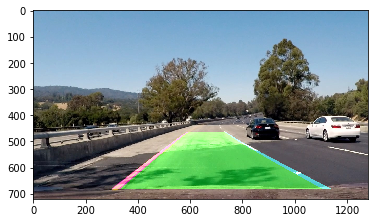

In [46]:
exImg_out1 = draw_lane(exImg, exImg_bin, left_fit, right_fit, Minv)
plt.imshow(exImg_out1)

## (H) Draw Curvature Radius and Distance from Center Data onto the Original Image
Define a function to draw radius/distance from centre on original image, function processing steps are:

1. Inputs : original_img, curv_rad, center_dist
2. Output : new_img
3. processing : 
   (a) Initailise local variable - image, height, font
   (b) Prepare text and put on image
   (c) check centre_dist <0 or >0 to decide direction
   (d) Put distance on image

In [47]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius : ' + '{: 04.2f}'.format(curv_rad) + ' m'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
        
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + ' m ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return new_img

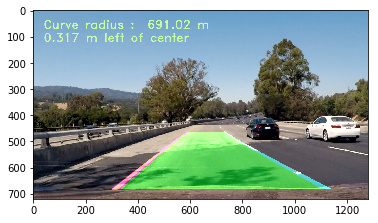

In [48]:
exImg_out2 = draw_data(exImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exImg_out2)

### (I) Define a class (Line) for Storing Data
Purpose of class is to store characterstic of each line, as described below:
(1) Input : None
(2) Output : None
(3) Attributes : Line class has 2 methods, as explained below:
    (a) _init_(self) method
        (i) initialize self variables
        (ii) was the line detected in the last iteration?
        (iii) x values of the last n fits of the line
        (iv) average x values of the fitted line over the last n iterations
        (v) polynomial coefficients averaged over the last n iterations
        (vi) polynomial coefficients for the most recent fit
        (vii) radius of curvature of the line in some units
        (viii)  distance in meters of vehicle center from the line
        (ix) difference in fit coefficients between last and new fits
        (x) number of detected pixels 
     (b) add_fit method - add a found fit to the line, up to n
         (i) Input : self, fit, inds
         (ii) Output : 
         (iii) Algorithm: 
             a. if fit fould we check - if we have a best fit, see how this new fit compares
             b. else remove one from the history, if not found

In [49]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False  
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None   #average x values of the fitted line over the last n iterations  
        self.best_fit = None  #polynomial coefficients averaged over the last n iterations
        self.current_fit = []  #polynomial coefficients for the most recent fit 
        self.radius_of_curvature = None #radius of curvature of the line in some units
        self.line_base_pos = None  #distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits
        self.px_count = None #number of detected pixels
        
    def add_fit(self, fit, inds): # add a found fit to the line, up to n  
        if fit is not None:
            if self.best_fit is not None: # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                self.detected = False # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5: # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:  # or remove one from the history, if not found
            self.detected = False
            if len(self.current_fit) > 0: # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)  # if there are still any fits in the queue, best_fit is their average

## (J) Define Complete Image Processing Pipeline
We are heading towards final pipeline for image processing, here is description of method (process_image(img)) adopted.
(a) Input : image 
(b) Output :  image
(c) Algorithm : here are steps of processing
    (1) Copy image in a variable and do preprocess through pipeline
    (2) if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    (3) invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    (4) draw the current best fit if it exists
    (5) put together multi-view output
    (6) return diagnosed image

In [50]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline_process(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None    
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output: # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360)) # original output (top left)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))  # binary overhead view (top right)
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        img_bin_fit = np.copy(img_bin)  # overhead with all fits added (bottom right)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        color_ok = (200,255,155)     # diagnostic data (bottom left)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

### Method for plotting a fit on a binary image - diagnostic purposes
Method defined with following attributes;
(a) Input - img, fit, plot_color
(b) Output - new image
(c) Algorithm - if fit none retung image as is otherwise plot polylines. 

In [51]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

## (K) Process Project Video
Purpose of this section is to run Line class on a input video. Step by step execution is such as;
(a) l_line and r_line variables initialized with Line class
(b) Output video file path prepared
(c) project_video file read in a variable by VideoFileClip() 
(d) video input file processed through - video_input1.fl_image(process_image) call and process_image pipeline
(e) final outcome printed in a output file (video_output1)

In [52]:
from datetime import datetime

l_line = Line()
r_line = Line()     
dt = datetime.now()         #my_clip.write_gif('test.gif', fps=12)
strg = '{:%B %d, %Y}'.format(dt)     # str.format
video_output1 = 'project_video_output_' + strg + '.mp4'

video_input1 = VideoFileClip('project_video.mp4')     #.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output_January 15, 2018.mp4
[MoviePy] Writing video project_video_output_January 15, 2018.mp4


100%|█████████▉| 1260/1261 [01:57<00:00, 10.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_January 15, 2018.mp4 

CPU times: user 9min 26s, sys: 2.23 s, total: 9min 28s
Wall time: 1min 57s


## (L) Process Challenge Video
Purpose of this section is to run Line class on a input video. Step by step execution is such as; (a) l_line and r_line variables initialized with Line class (b) Output video file path prepared (c) project_video file read in a variable by VideoFileClip() - challenge_video.mp4 (d) video input file processed through - video_input2.fl_image(process_image) call and process_image pipeline (e) final outcome printed in a output file (video_output2)

In [53]:
l_line = Line()
r_line = Line()

dt = datetime.now()         # my_clip.write_gif('test.gif', fps=12)
strg = '{:%B %d, %Y}'.format(dt)     # str.format
video_output2 = 'challenge_video_output_' + strg + '.mp4'

video_input2 = VideoFileClip('challenge_video.mp4')  #.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s

processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output_January 15, 2018.mp4
[MoviePy] Writing video challenge_video_output_January 15, 2018.mp4


100%|██████████| 485/485 [00:41<00:00, 11.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output_January 15, 2018.mp4 

CPU times: user 3min 21s, sys: 1.02 s, total: 3min 22s
Wall time: 41.8 s


## (M) Process Harder Challenge Video
Purpose of this section is to run Line class on a input video. Step by step execution is such as; (a) l_line and r_line variables initialized with Line class (b) Output video file path prepared (c) project_video file read in a variable by VideoFileClip() - harder_challenge_video.mp4 (d) video input file processed through - video_input3.fl_image(process_image) call and process_image pipeline (e) final outcome printed in a output file (video_output3)

In [54]:
l_line = Line()
r_line = Line()

dt = datetime.now()         # my_clip.write_gif('test.gif', fps=12)
strg = '{:%B %d, %Y}'.format(dt)     # str.format
video_output3 = 'harder_challenge_video_' + strg + '.mp4'

video_input3 = VideoFileClip('harder_challenge_video.mp4')  #.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s

processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_January 15, 2018.mp4
[MoviePy] Writing video harder_challenge_video_January 15, 2018.mp4


100%|█████████▉| 1199/1200 [02:16<00:00,  8.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_January 15, 2018.mp4 

CPU times: user 10min 24s, sys: 2.25 s, total: 10min 26s
Wall time: 2min 16s
